In [5]:
import numpy as np
import pandas as pd 
import re 
import torch 
import torch.nn as nn
import sklearn
import torch.nn.functional as F
from nltk.tokenize import word_tokenize
from torch.utils.data import DataLoader,Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [6]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device

'cuda'

# **document similarty score**
*this one of the fundemental area of NLP there are several methods proposed to do this taks*

**top methods**

1. Cosine Similarity
*here we will be converting documents into vectors and apply for this vector conversion we normally use Term Frequency-Inverse Document Frequency and the dot product between two docs represent the similarity*

*this method doesnt take capture the semantic meaning of words for example teacher and professor are consider like different individual*

2. Word Embedding-Based Methods
*in this method we fine-tune/train numerical word embeddings based on their occurance in a sentence*
*for this there are two widely used architecture are 'Continuous Bag-of-Words' and 'skip gram'*

**Continuous Bag-of-Words**
*predicts the middle word based on surrounding context words. The context consists of a few words before and after the current (middle) word.*

**example**
> i am rohith currenty pursuing btech 

> given "i am rohith ---- pursuing btech" the model will predict the currently

> we will be updating the embedding layer weights through backprop

**skip gram model**
*predicts words within a certain range before and after the current word in the same sentence. A worked example of this is given below.*

**example**

> i am rohith currenty pursuing btech 

> given "pursuing" the model will predict the i am rohith  pursuing btech

> we will be updating embedding layer weights through backprop

**skip gram model is able to get better semantic and Syntactic accuracy then cbow model so we will be implementing the skip gram model to get the word embeddings**

*source https://arxiv.org/pdf/1301.3781.pdf (Efficient Estimation of Word Representations in Vector Space)*

In [7]:
with open('/kaggle/input/document-classification/file.txt','r') as f:
    data = f.read()
data = segments = re.split(r'\n[1-9]', data)

In [8]:
tokenized_corpus = []
for sentence in data:
    tokens = word_tokenize(sentence)
    tokenized_corpus.extend(tokens)

In [9]:
print(tokenized_corpus[1000])

div


In [10]:
idx = 1
word_to_num_dict = {}
for word in tokenized_corpus:
    if(word not in word_to_num_dict.keys()):
        word_to_num_dict[word]=idx
        idx+=1
vocab_size = len(word_to_num_dict)
vocab_size

19982

In [11]:
num_to_word_dict = {value: key for key, value in word_to_num_dict.items()}

**the dataset contains 19982 unique words** 

In [12]:
x = []
y = []
for token in tokenized_corpus:
    for i in range(2, len(token) - 2):
        center_word_idx = word_to_num_dict[token[i]]
        context_word_indices = [word_to_num_dict[token[j]] for j in range(i-2, i+3) if j != i] 
        x.append(center_word_idx)
        y.append(context_word_indices)

In [13]:
x = torch.tensor(x)
y = torch.tensor(y)
x.to(device)
y.to(device)

tensor([[1127, 2061, 2160,  480],
        [2061,   15,  480,  271],
        [  15, 2160,  271,  377],
        ...,
        [  15,  458,  377,   57],
        [1126,  269,  458,  269],
        [ 269,  489,  269, 1126]], device='cuda:0')

**Dataset and DataLoader**

In [14]:
class customdataset(Dataset):
    def __init__(self,x,y):
        self.inputs = x
        self.outputs = y
    def __len__(self):
        return len(self.inputs)
    def __getitem__(self,idx):
        return self.inputs[idx],self.outputs[idx]

In [15]:
dataset = customdataset(x,y)

In [16]:
Loader = DataLoader(dataset,batch_size=128,num_workers=0)

**Skip gram model**

In [17]:
class skip_gram(nn.Module):
    def __init__(self,vocab_size,dimension):
        super(skip_gram,self).__init__()
        self.dimension=dimension
        self.target_embedding = nn.Embedding(vocab_size,dimension)
        self.context_embedding = nn.Embedding(vocab_size,dimension)
    def forward(self,target,context):
        if(len(target.size())==2):
            target=target.squeeze(axis=1)
        target_embedding = self.target_embedding(target)
#         print(target_embedding.shape)
        context_embedding = self.context_embedding(context)
#         print(context_embedding.shape)
        logits = torch.einsum('be,bce->bc',target_embedding,context_embedding)
        return logits

In [18]:
model = skip_gram(19983,300).to(device)

In [19]:
import torch.optim as optim 
optimizer = optim.Adam(model.parameters(),lr=0.01)

In [20]:
model.train()
epochs = 5
losses = []
best_run = 100
for e in range(epochs):
    net_batch_loss = 0
    cnt = 0
    early_stop = 0
    for target,context in tqdm(Loader):
        batch_size = target.shape[0]
        optimizer.zero_grad()
        pred = model(target.to(device),context.to(device))
        ground_truth = torch.ones(batch_size*4).view(batch_size,4)
        ground_truth = ground_truth.to(device)
        loss = F.cross_entropy(pred,ground_truth)
        loss.backward()
        optimizer.step()
        cnt+=1
        net_batch_loss+=loss.item()
    if(net_batch_loss/cnt<best_run):
        torch.save(model.state_dict(),f'/kaggle/working/{e}th.pth')
        best_run = net_batch_loss/cnt
        early_stop = 0
    early_stop+=1
    losses.append(net_batch_loss/cnt)
    print(f'loss at the {e}th epoch is {net_batch_loss/cnt}')
    if(early_stop>=5):
        print('early stopping due to no improvement')
        break

100%|██████████| 6233/6233 [00:44<00:00, 140.72it/s]


loss at the 0th epoch is 6.327361678572235


100%|██████████| 6233/6233 [00:42<00:00, 147.93it/s]


loss at the 1th epoch is 5.838369319627512


100%|██████████| 6233/6233 [00:41<00:00, 148.78it/s]


loss at the 2th epoch is 5.602435037027521


100%|██████████| 6233/6233 [00:41<00:00, 148.67it/s]


loss at the 3th epoch is 5.548454720500039


100%|██████████| 6233/6233 [00:42<00:00, 147.89it/s]


loss at the 4th epoch is 5.546205582673029


In [21]:
pre_trained = torch.load('/kaggle/working/4th.pth')

In [22]:
pre_trained.keys()

odict_keys(['target_embedding.weight', 'context_embedding.weight'])

In [23]:
weights = pre_trained['target_embedding.weight']

In [24]:
weights = weights.cpu().numpy()

In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(weights)

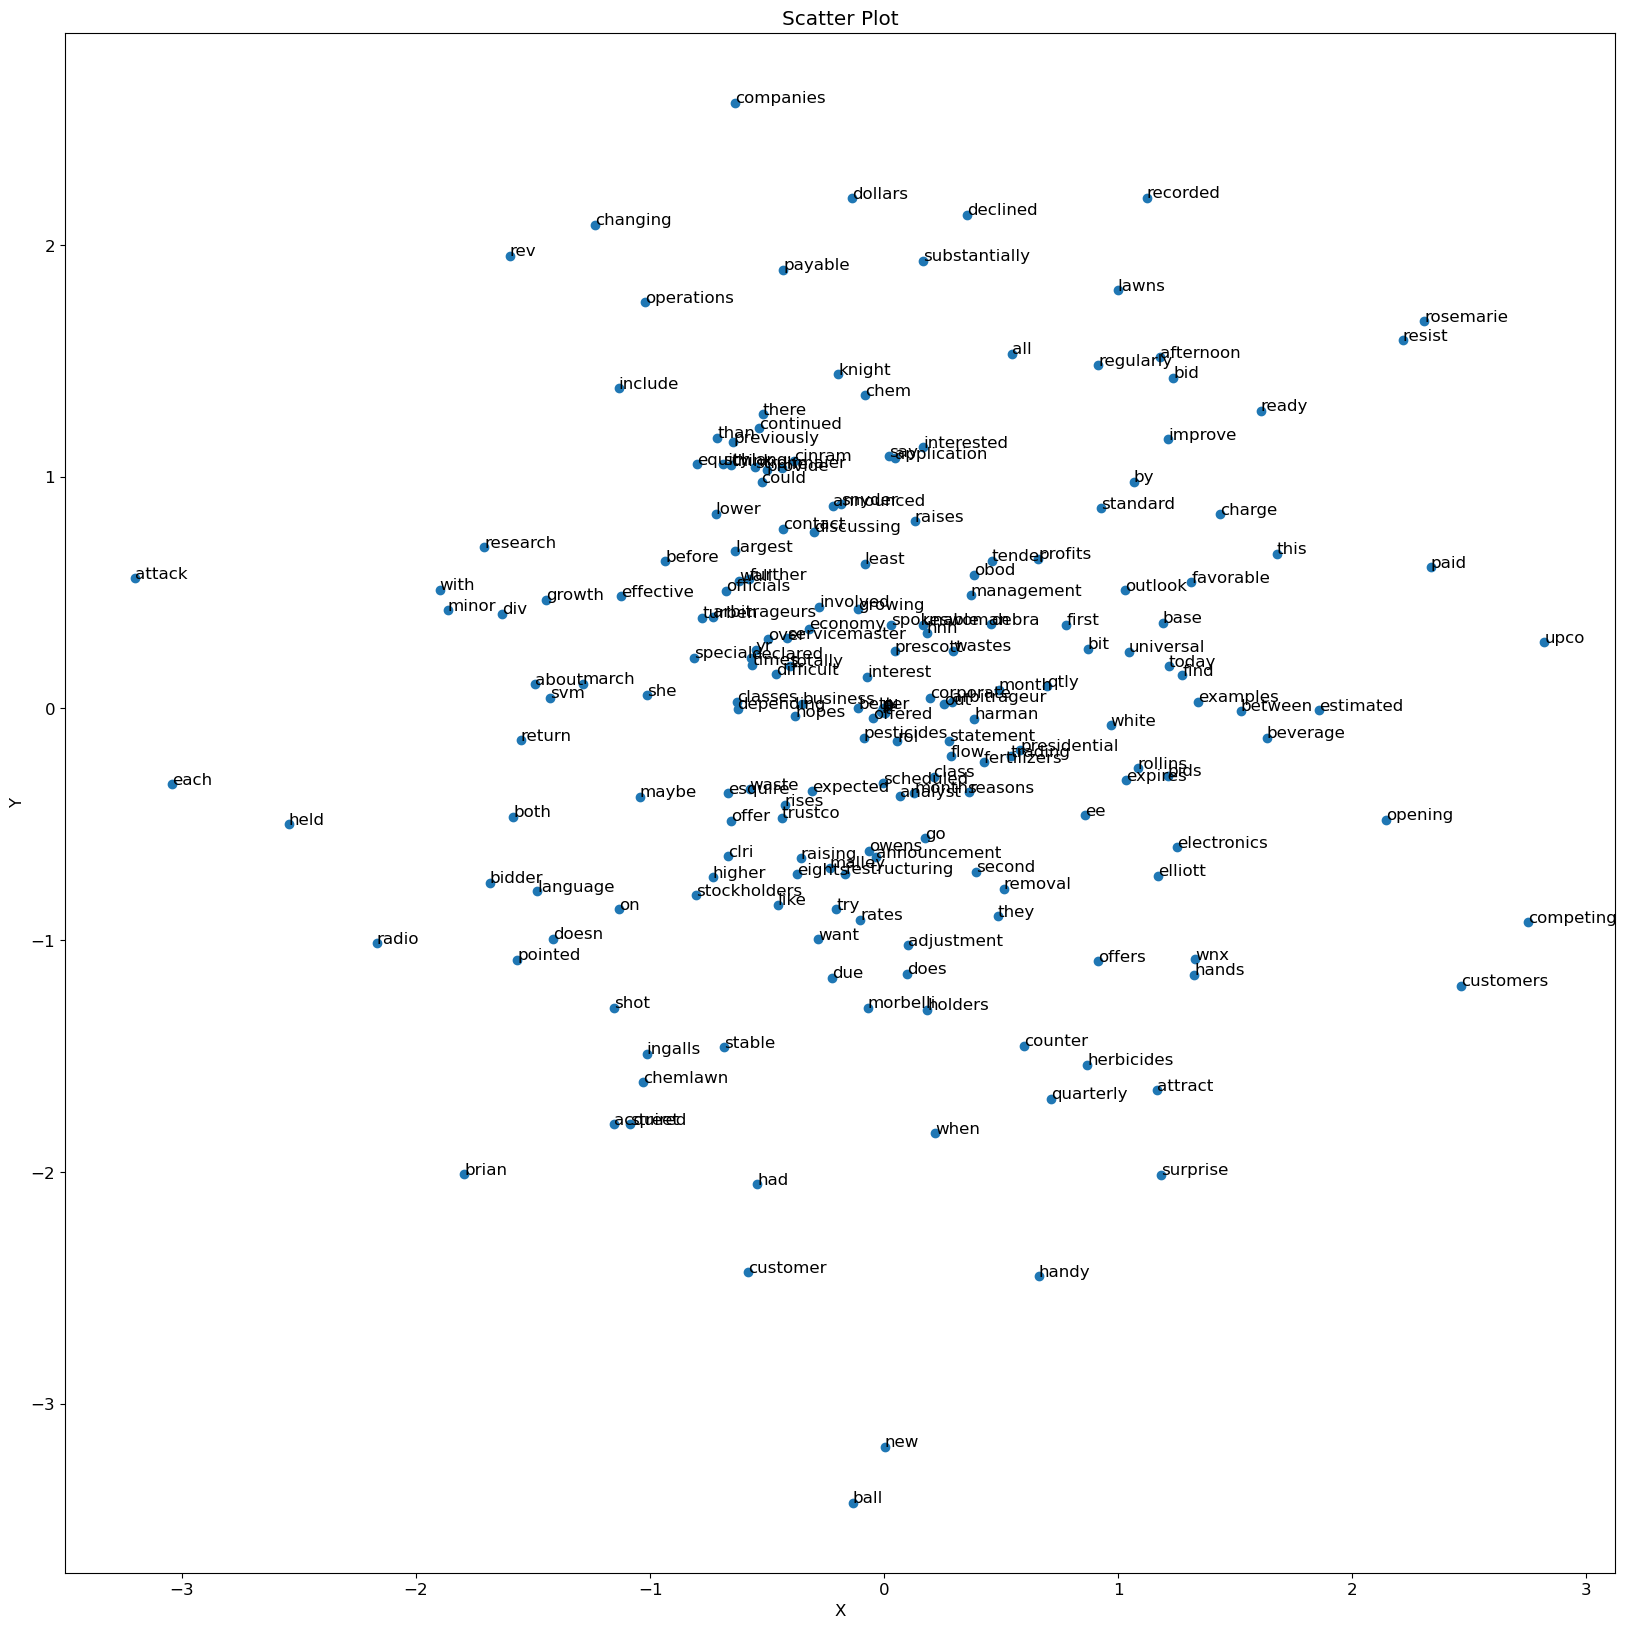

In [26]:

x_values = [point[0] for point in reduced_data[300:500]]
y_values = [point[1] for point in reduced_data[300:500]]
titles = [ num_to_word_dict[point] for point in range(300,500)]
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(20,20)) 
plt.scatter(x_values, y_values)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot')
for i, title in enumerate(titles):
    plt.text(x_values[i], y_values[i], title)
plt.show()


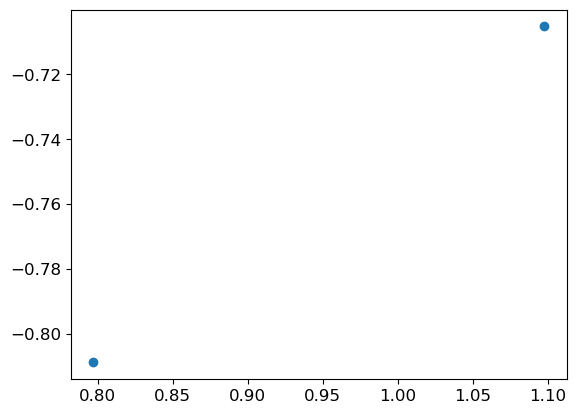

In [27]:
p1 = weights[word_to_num_dict['office']]
p2 = weights[word_to_num_dict['boss']]
x_val = [p1[0],p2[0]]
y_val = [p1[1],p2[1]]
plt.scatter(x_val,y_val)